# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

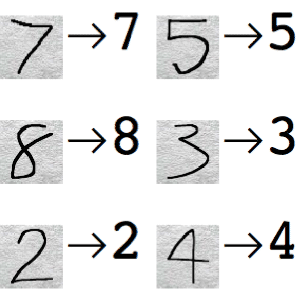

In [1]:
# Change #0
import warnings
warnings.filterwarnings('ignore')

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


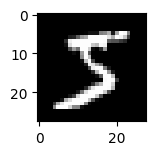

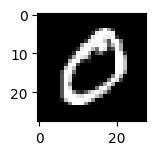

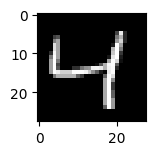

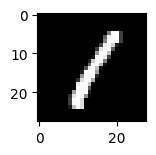

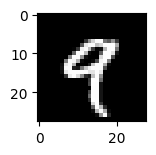

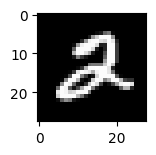

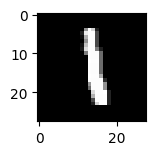

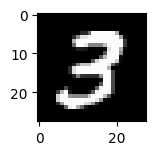

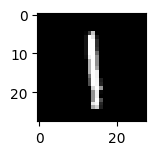

In [2]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [3]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [4]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [5]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [6]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [7]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [8]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [9]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [10]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.458
> 98.550
> 98.600
> 98.867
> 98.650


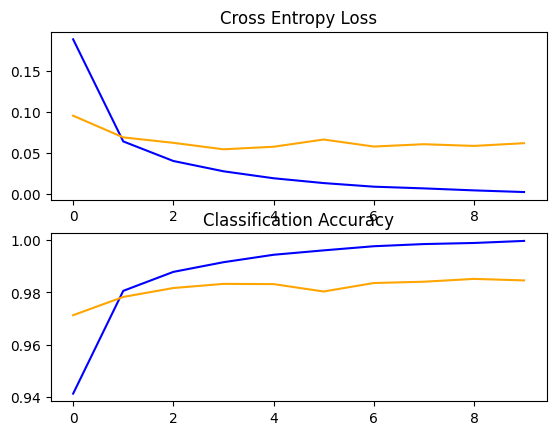

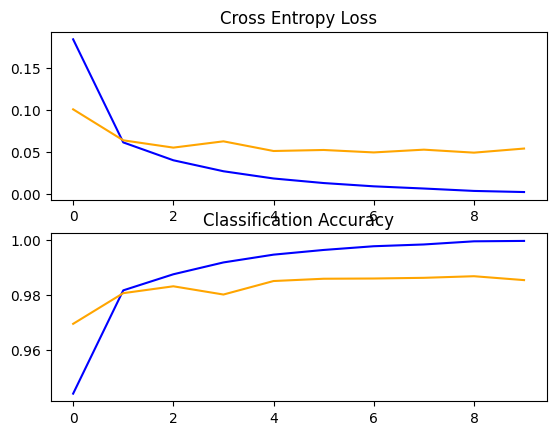

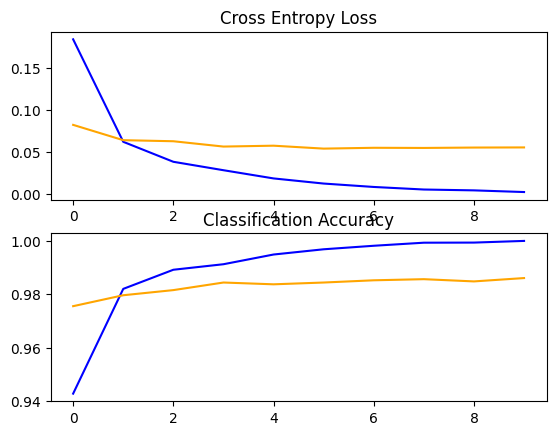

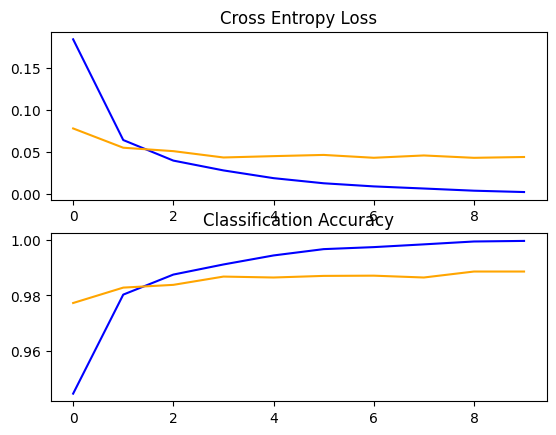

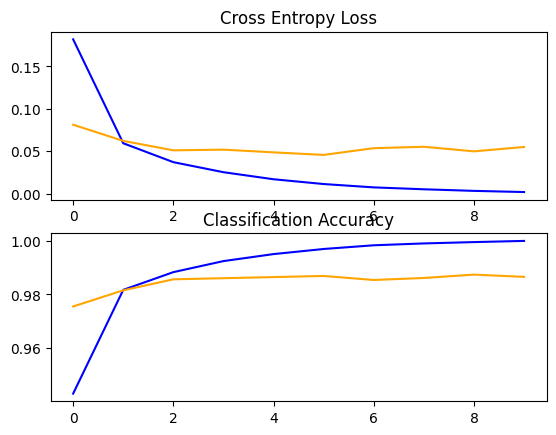

Accuracy: mean=98.625 std=0.136, n=5


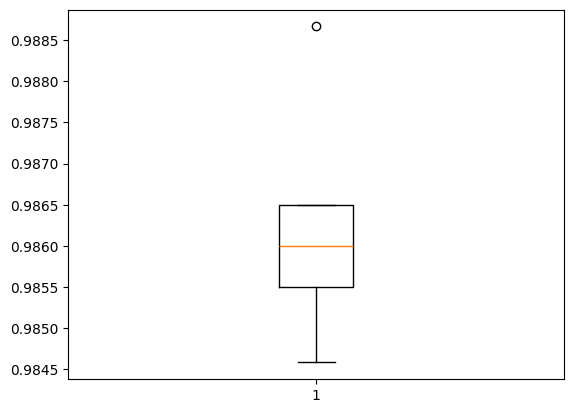

In [11]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [12]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

## Evaluate Final Model

In [13]:
run_test_harness2()

## Make Prediction

In [14]:
# Change #1

from PIL import Image

def resize_with_more_accurate(filename):
  # Load the image
  img = Image.open(filename)

  # Convert the image to grayscale using the ITU-R BT.709 color space
  img = img.convert('L')

  # Resize the image using bilinear interpolation
  new_width = 28
  new_height = 28
  img = img.resize((new_width, new_height), Image.BILINEAR)

  # Save the resized image
  img.save('temp.png')

In [15]:
def load_image(filename, reversed_grayscale=False):
  # Change #2
  
  # load the image
  resize_with_more_accurate(filename)
  img = load_img('temp.png', color_mode='grayscale', target_size=(28, 28))

  # convert to array
  img = img_to_array(img)
  
  # Change #3
  # reverse grayscale
  if reversed_grayscale:
    img = 255 - img
  
  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

In [16]:
# Change #4

def show_image(img):    
  img2 = img.reshape(28, 28)
  plt.imshow(img2, cmap = 'gray')
  plt.show()

In [17]:
# load an image and predict the class
def run_example():
  # load the image
  # Change #5

  img = load_image('sample_image.png', reversed_grayscale=True)
  show_image(img)
  # load model
  model = load_model('final_model.h5')

  # predict the class
  predict_value = model.predict(img)

  digit = argmax(predict_value)
  print(digit)



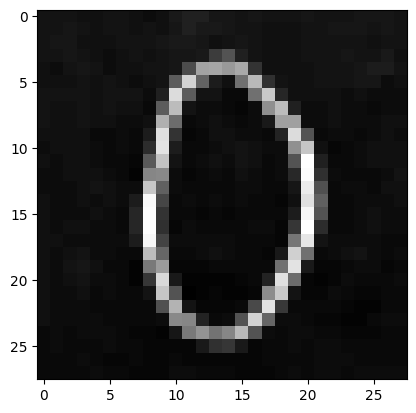

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
0


In [18]:
# entry point, run the example
run_example()

Testing

In [19]:
# Change #6

# Loading model and data folder
testFolder = 'data'
import glob
model = load_model('final_model.h5')

# Extracting student IDs
correct = []
wrong = []
MSSVs = glob.glob(f'{testFolder}/*')
MSSVs = [name[-8:] for name in MSSVs]

# Iterating through dataset
for MSSV in MSSVs:
  for i in range(10):
    files = glob.glob(f'{testFolder}/{MSSV}/{i}/*')
    for f in files:
      img = load_image(f, reversed_grayscale=True)
      predict_value = model.predict(img)
      digit = argmax(predict_value)
      # Output the prediction
      if digit == i:
        print('Correct: ', f, '-', digit)
        correct.append(f)
      else:
        print('Wrong:', f, '-' , digit)
        wrong.append(f)
        #show_image(img)

# Output overall result
print('Correct: ', len(correct))
print('Wrong:', len(wrong))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Correct:  data/22520488/0\0(2).png - 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Correct:  data/22520488/0\0(3).png - 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Correct:  data/22520488/0\0.png - 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Correct:  data/22520488/1\1(2).png - 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Wrong: data/22520488/1\1(3).png - 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Correct:  data/22520488/1\1.png - 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Correct:  data/22520488/2\2(2).png - 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Correct:  data/22520488/2\2(3).png - 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Correct:  data/22520488/2\2.png - 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Correct:  data/22520488/3\3(2).png - 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Correct:  data/22520488/3\3(3).png - 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Correct:  data/22520488/3\3.png - 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Correct:  data/22520488/4\4(2).png - 4
1/1 ━━━━━━━━━━

# Các thay đổi đã thực hiện trên Notebook:

### Change #0
Loại bỏ tất cả warning.
### Change #1
Resize hình ảnh về size 28x28, dùng ITU-R BT.709 color space với thư viện Pillow để đạt được grayscale chính xác hơn, lưu tạm vào file temp.png.
### Change #2
Thay đổi lời gọi hàm với tham số thêm reversed_grayscale, load ảnh temp.png.
### Change #3
Do dataset là nền trắng chữ đen thay vì nền đen chữ trăng như bộ MNIST dùng để train, dùng để đảo ngược màu hình lại.
### Change #4
Thêm hàm xuất ảnh.
### Change #5
Lời gọi hàm trong run_example được thêm tham số reverse_grayscale
### Change #6
Thêm cell test model bằng dataset tự tạo.